In [18]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style('whitegrid') 
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)
np.random.seed(42)

with pd.HDFStore('../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']
    
with pd.HDFStore('../data/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

start, end = 2008, 2017 
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
periods_per_year = round(weekly_returns.resample('A').size().mean())
n_obs, n_assets = weekly_returns.shape

NUM_PF = 100000 # no of portfolios to simulate
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()
stocks = weekly_returns.columns
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())
rf_rate = treasury_10yr_monthly.mean()

In [20]:
def simulate_portfolios(short=False):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    pf_returns = weights @ weekly_returns.T
    returns = (pf_returns + 1).mean(1) ** periods_per_year - 1
    std = pf_returns.std(1) * np.sqrt(periods_per_year)
    
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

simul_perf, simul_wt = simulate_portfolios()
"""
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')

plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()
"""

"\nax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',\n                             alpha=0.5, figsize=(14, 9), colorbar=True,\n                             title=f'{NUM_PF:,d} Simulated Portfolios')\n\nmax_sharpe_idx = simul_perf.iloc[:, 2].idxmax()\nsd, r = simul_perf.iloc[max_sharpe_idx, :2].values\nax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')\nprint(f'Max Sharpe: {sd:.2%}, {r:.2%}')\n\nmin_vol_idx = simul_perf.iloc[:, 0].idxmin()\nsd, r = simul_perf.iloc[min_vol_idx, :2].values\nax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')\n\nplt.legend(labelspacing=1, loc='upper left')\nplt.tight_layout()\n"

In [23]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year) #wt.shape = (25,),因此函数返回标量

def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

def maximize_sharpe_ratio(mean_ret, cov, short=False):
    weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x))-1}
    
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

def minimize_vol_target(mean_ret, cov, target_return, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1}
    return_constraint = {'type': 'eq', 'fun': lambda x: ret_(x) - target_return}

    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=[return_constraint, weight_constraint],
                    options={'tol': 1e-10, 'maxiter': 1e4})

def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [minimize_vol_target(mean_ret, cov, ret) for ret in ret_range]

def minimize_vol_global(mean_ret, cov, short=False):
    weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1}
    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [24]:
#二次优化- 最大SR
max_sharpe_solution = maximize_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_pf = portfolio_performance(max_sharpe_solution.x, mean_returns, cov_matrix)

#二次优化- 给定return最小化方差
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

#二次优化- 全局最小方差法
min_vol_global_solution = minimize_vol_global(mean_returns, cov_matrix)
min_vol_global_pf = portfolio_performance(min_vol_global_solution.x, mean_returns, cov_matrix)

#1/N等权法
eq_w_pf = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)

#全球投资组合优化 – Black-Litterman法，第10章？

#凯利准则 最佳投资-单资产，在下个ipynb

#凯利准则 最佳投资-多资产
kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
kelly_multi_pf = portfolio_performance(kelly_wt, mean_returns, cov_matrix)

#风险平价法
std = weekly_returns.std()
std /= std.sum()
risk_parity_pf = portfolio_performance(std, mean_returns, cov_matrix)

Max Sharpe: 21.26%, 30.87%


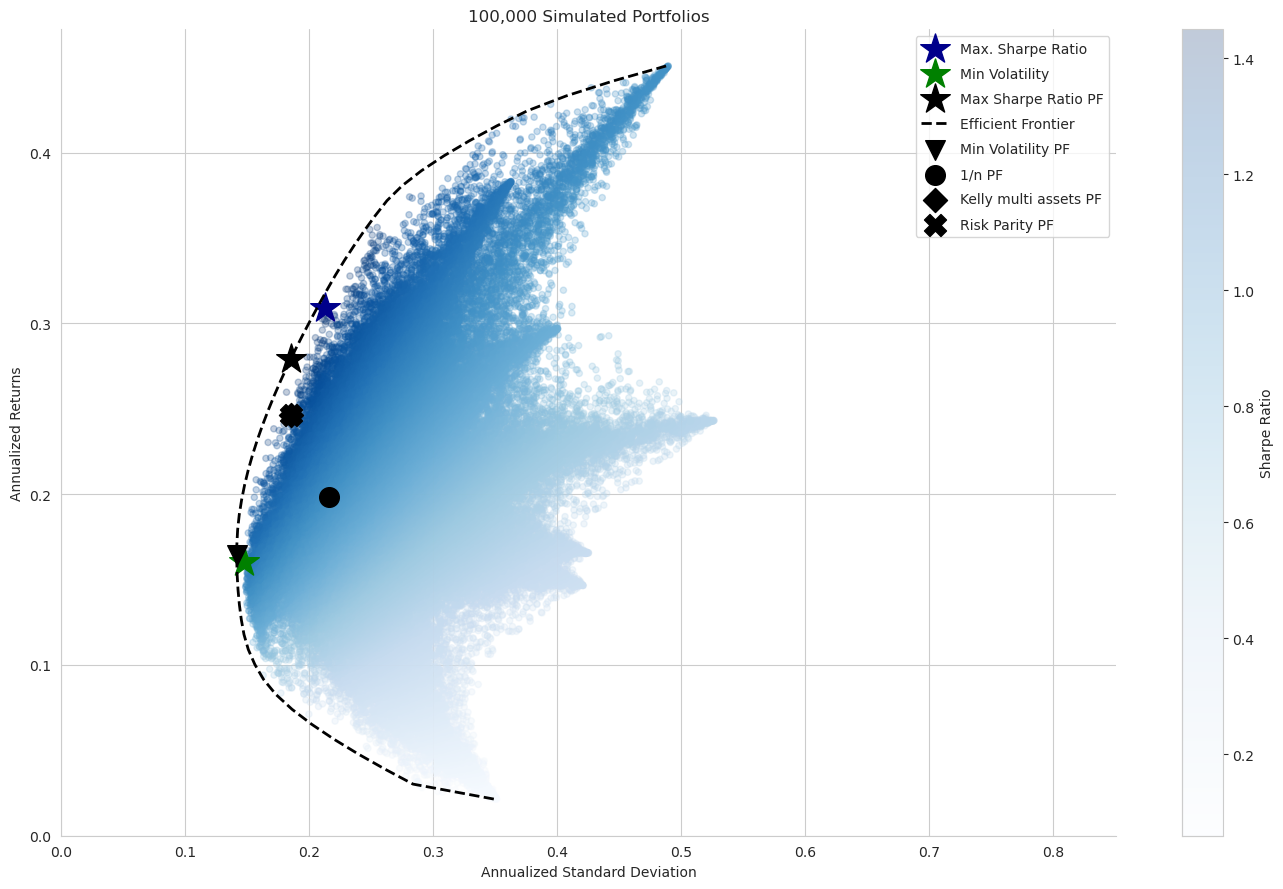

In [35]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, figsize=(14, 9), colorbar=True,
                        title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')

r, sd = max_sharpe_pf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

#eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k', label='Efficient Frontier')
eff_pf.plot(linestyle='--', lw=2, ax=ax, c='k', label='Efficient Frontier')

r, sd = min_vol_global_pf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

r, sd = eq_w_pf
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')

r, sd = kelly_multi_pf
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly multi assets PF')

risk_parity_pf = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
#ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
#ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();

#plt.legend(labelspacing=1, loc='upper left')
#plt.tight_layout()